<a href="https://colab.research.google.com/github/beautifulv0id/Dermatological-Moles-Segmentation/blob/main/Dermatological_moles_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloading the data

In [ ]:
!wget -N https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_Data.zip
!wget -N https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_GroundTruth.zip
!unzip -n ISBI2016_ISIC_Part1_Training_Data
!unzip -n ISBI2016_ISIC_Part1_Training_GroundTruth

--2022-10-22 07:20:48--  https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_Data.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.217.159.33
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.217.159.33|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘ISBI2016_ISIC_Part1_Training_Data.zip’ not modified on server. Omitting download.

--2022-10-22 07:20:49--  https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_GroundTruth.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 3.5.11.188
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|3.5.11.188|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘ISBI2016_ISIC_Part1_Training_GroundTruth.zip’ not modified on server. Omitting download.

Archive:  ISBI2016_ISI

## Prepare paths of input images and target segmentation masks

In [ ]:
import os

input_dir = "ISBI2016_ISIC_Part1_Training_Data/"
target_dir = "ISBI2016_ISIC_Part1_Training_GroundTruth/"
img_size = (160, 160)
num_classes = 1
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 900
ISBI2016_ISIC_Part1_Training_Data/ISIC_0000000.jpg | ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0000000_Segmentation.png
ISBI2016_ISIC_Part1_Training_Data/ISIC_0000001.jpg | ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0000001_Segmentation.png
ISBI2016_ISIC_Part1_Training_Data/ISIC_0000002.jpg | ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0000002_Segmentation.png
ISBI2016_ISIC_Part1_Training_Data/ISIC_0000004.jpg | ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0000004_Segmentation.png
ISBI2016_ISIC_Part1_Training_Data/ISIC_0000006.jpg | ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0000006_Segmentation.png
ISBI2016_ISIC_Part1_Training_Data/ISIC_0000007.jpg | ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0000007_Segmentation.png
ISBI2016_ISIC_Part1_Training_Data/ISIC_0000008.jpg | ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0000008_Segmentation.png
ISBI2016_ISIC_Part1_Training_Data/ISIC_0000009.jpg | ISBI2016_ISIC_Part1_Training_GroundTruth/ISIC_0000009_Se

## What does one input image and corresponding segmentation mask look like?

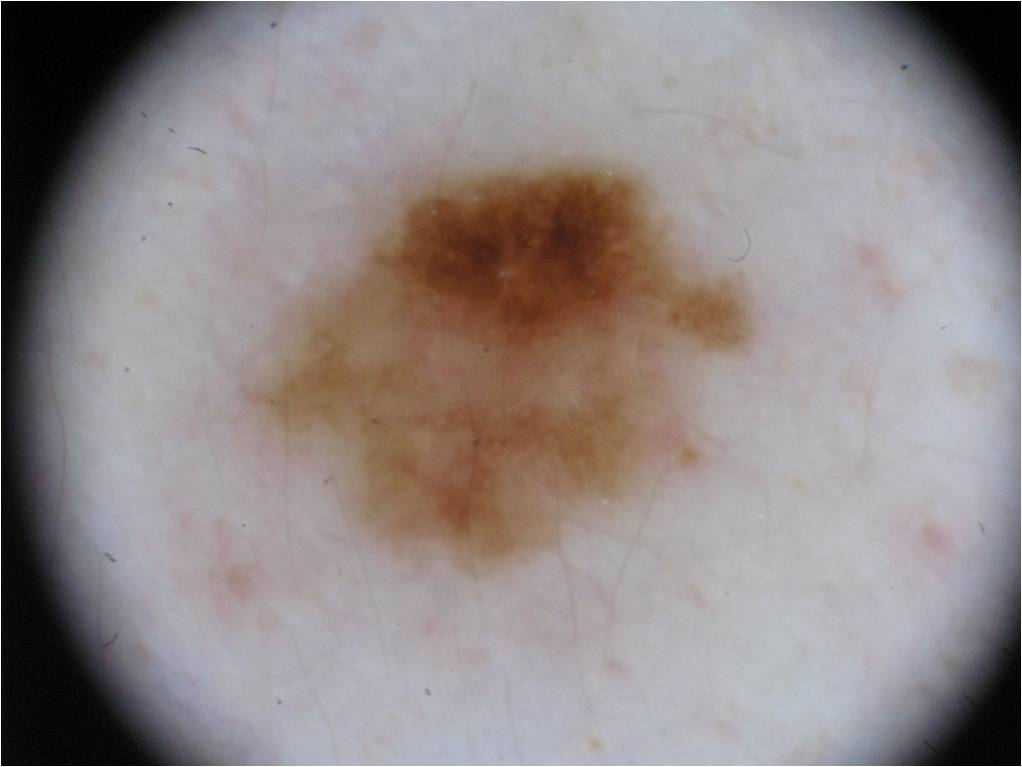

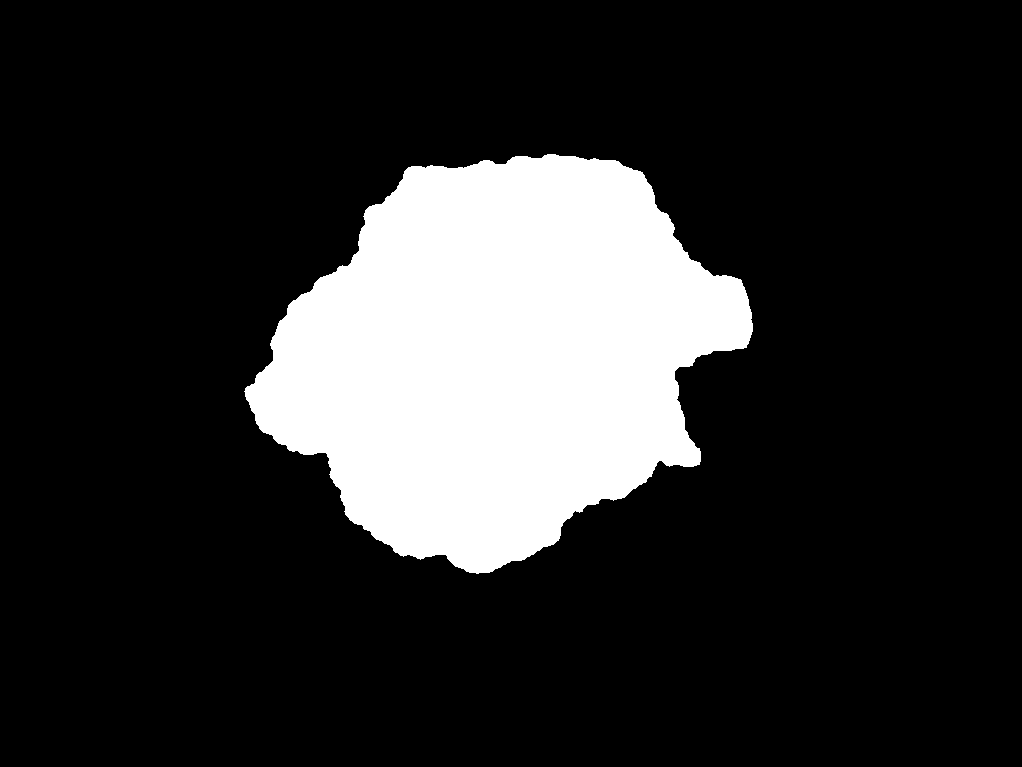

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

## Prepare `Sequence` class to load & vectorize batches of data

Currently images are all scaled to size `(160, 160)` even though original input images are much bigger. Furthermore, had to adjust script to get correct labels for ground truth images.

In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

class DermatologicalMoles(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 0, 255. Add one to make them 0, 1:
            y[j] += 1
        x = torch.tensor(x)
        x.ma
        return x, y


## Prepare U-Net Xception-style model

Change `softmax` activation to `sigmoid` for binary classification setting.

In [ ]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel sigmoid classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

## Set aside a validation split

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 50
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = DermatologicalMoles(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = DermatologicalMoles(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## Data Augmentation

In [ ]:
# we create two instances with the same arguments
data_gen_args = dict(samplewise_center=True, 
                     samplewise_std_normalization= True,
                     rotation_range=5,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range = 0.02,
                     zoom_range=0.02)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
#image_datagen.fit(images, augment=True, seed=seed)
#mask_datagen.fit(masks, augment=True, seed=seed)
image_generator = image_datagen.flow_from_directory(
    'data/images',
    class_mode=None,
    seed=seed)
mask_generator = mask_datagen.flow_from_directory(
    'data/masks',
    class_mode=None,
    seed=seed)
# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

## Train the model
Since we are in normal classification setting use `binary_crossentropy` for the loss.

In [ ]:
# Configure the model for training.
# We use the binary_crossentropy because our target data binary.
model.compile(optimizer="rmsprop", loss="binary_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("mole_segmentation.h5", save_best_only=True)
]



1/1 [==============================] - 10s 10s/step


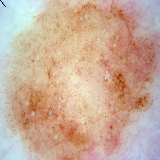

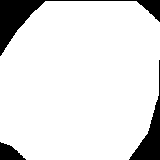

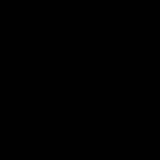

In [ ]:
i = 2
train_img = load_img(train_input_img_paths[i], target_size=img_size)
train_img = np.expand_dims(train_img, 0)

img = ImageOps.autocontrast(load_img(train_input_img_paths[i], target_size=img_size))
mask_gt = ImageOps.autocontrast(load_img(train_target_img_paths[i], target_size=img_size))

test_pred = model.predict(train_img)

display(img)
display(mask_gt)

mask = np.where(test_pred < 0.5, 0, 1)
mask = np.squeeze(mask, 0)
mask = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
display(mask)

In [ ]:
# Train the model, doing validation at the end of each epoch.
epochs = 30
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/30
26/26 [==============================] - 47s 2s/step - loss: 1.0150 - val_loss: 3.2856
Epoch 2/30
26/26 [==============================] - 38s 1s/step - loss: 0.3626 - val_loss: 0.5082
Epoch 3/30
26/26 [==============================] - 38s 1s/step - loss: 0.2816 - val_loss: 0.5539
Epoch 4/30
26/26 [==============================] - 39s 1s/step - loss: 0.2670 - val_loss: 0.7830
Epoch 5/30
26/26 [==============================] - 38s 1s/step - loss: 0.2148 - val_loss: 0.7052
Epoch 6/30
26/26 [==============================] - 38s 1s/step - loss: 0.1978 - val_loss: 1.3495
Epoch 7/30
26/26 [==============================] - 39s 2s/step - loss: 0.1892 - val_loss: 1.2985
Epoch 8/30
26/26 [==============================] - 41s 2s/step - loss: 0.1649 - val_loss: 1.5868
Epoch 9/30
26/26 [==============================] - 39s 1s/step - loss: 0.1672 - val_loss: 1.2447
Epoch 10/30
26/26 [==============================] - 40s 2s/step - loss: 0.1505 - val_loss: 1.0667
Epoch 11/30
26/26 [

## Visualize predictions

1/1 [==============================] - 2s 2s/step


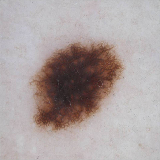

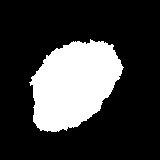

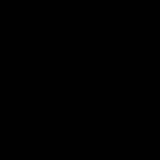

In [ ]:
# Generate predictions for all images in the validation set

val_gen = DermatologicalMoles(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    pred = val_preds[i]
    mask = np.where(pred > 0.5, 0, 1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image

display(load_img(val_input_img_paths[i], target_size=img_size))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i], target_size=img_size))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 160x160.

## Evaluation
Considered metrics computed are: `sensitivity`, `specificity`, `accuracy`, `Jaccard index` and `Dice`.

In [ ]:
val_target = load_img(val_input_img_paths[0])
print(val_preds[0].shape)
preds_orig_size = keras.preprocessing.image.smart_resize(val_preds[0], val_target.size)
print(preds_orig_size.shape)


(160, 160, 1)
(1024, 768, 1)


In [ ]:
p = np.array([[1, 1, 0]])
v = np.array([[0, 1, 1]])
tmp = v[np.where(p == 1)]
tp = np.count_nonzero(tmp)
fp = len(tmp) - tp
print(tp)
print(fp)


1
1


In [ ]:
fp = 0.
fn = 0.
tn = 0.
tp = 0.
for i, pred in enumerate(val_preds):
  target = np.array(load_img(val_target_img_paths[i], color_mode="grayscale"), dtype="uint8")
  target += 1
  target = keras.preprocessing.image.img_to_array(target)
  pred_orig_size = keras.preprocessing.image.smart_resize(pred, target.shape[:-1], interpolation='bilinear')
  pred_mask = np.where(pred_orig_size > 0.5, 0, 1)
  tmp = target[np.where(pred_mask == 1)]
  tp += np.count_nonzero(tmp==1)
  fp += np.count_nonzero(tmp==0)
  tmp = target[np.where(pred_mask == 0)]
  fn += np.count_nonzero(tmp==1)
  tn += np.count_nonzero(tmp==0)

sensivity = tp / (tp + fn)
specificity = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
dice = (2*tp) / (2*tp+fp+fn)
jaccard = tp / (tp + fp + fn)

print("sensivity: ", sensivity)
print("specificity: ", specificity)
print("accuracy: ", accuracy)
print("dice: ", dice)
print("jaccard: ", jaccard)


sensivity:  0.0
specificity:  0.9970469559122808
accuracy:  0.1546099970500459
dice:  0.0
jaccard:  0.0
